In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-b0atahi2
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-b0atahi2
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101058 sha256=aaa5df0551c6f423e30cfe6daa4b1288213bce9e26d6dead8b3d8d10a54cda61
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc27vl2m/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Concatenate, Activation, Dense, BatchNormalization, LeakyReLU, Reshape, 
                                     Conv2DTranspose, Conv2D, Dropout, Flatten, Dense, ZeroPadding2D)
from tensorflow import keras
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import img_to_array
from keras.utils import load_img
import datetime
import glob
import os
import time
from tqdm import tqdm
import numpy as np
from numpy.random import randn
from numpy.random import randint
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  1


In [5]:
!unzip '/content/drive/MyDrive/Datasets/vangogh2photo.zip'

Streaming output truncated to the last 5000 lines.
  inflating: vangogh2photo/trainB/2016-08-26 19:25:29.jpg  
  inflating: vangogh2photo/trainB/2016-02-20 16:54:25.jpg  
  inflating: vangogh2photo/trainB/2015-05-19 19:43:44.jpg  
  inflating: vangogh2photo/trainB/2015-10-26 21:18:58.jpg  
  inflating: vangogh2photo/trainB/2014-07-19 15:39:53.jpg  
  inflating: vangogh2photo/trainB/2015-06-13 21:21:54.jpg  
  inflating: vangogh2photo/trainB/2015-06-04 14:10:33.jpg  
  inflating: vangogh2photo/trainB/2014-06-18 12:46:34.jpg  
  inflating: vangogh2photo/trainB/2016-03-17 18:07:22.jpg  
  inflating: vangogh2photo/trainB/2015-01-24 17:24:29.jpg  
  inflating: vangogh2photo/trainB/2016-01-27 12:45:41.jpg  
  inflating: vangogh2photo/trainB/2016-06-14 05:57:28.jpg  
  inflating: vangogh2photo/trainB/2015-12-24 01:48:36.jpg  
  inflating: vangogh2photo/trainB/2015-10-18 05:19:51.jpg  
  inflating: vangogh2photo/trainB/2015-01-23 07:43:34.jpg  
  inflating: vangogh2photo/trainB/2016-04-29 18:0

In [6]:
def load_images(img_path, size=(256, 256)):
    img_list = list()
    for filename in tqdm(glob.glob(img_path + '/*')):
        pixels = load_img(filename, target_size=size)
        pixels = img_to_array(pixels)
        pixels = (pixels-127.5)/127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [7]:
trainB = load_images('vangogh2photo/trainA')

100%|██████████| 400/400 [00:01<00:00, 371.79it/s]


In [8]:
trainA = load_images('vangogh2photo/trainB')

100%|██████████| 6287/6287 [00:19<00:00, 319.83it/s]


In [9]:
testB = load_images('vangogh2photo/testA')

100%|██████████| 400/400 [00:01<00:00, 285.50it/s]


In [10]:
testA = load_images('vangogh2photo/testB')

100%|██████████| 751/751 [00:04<00:00, 157.86it/s]


In [11]:
def resnet_block(n_filters, input_layer):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=initializer)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    g = Activation('relu')(g)
    return g

In [12]:
def generator(img_shape = (256,256), n_resnet = 9):
    initializer = tf.random_normal_initializer(0., 0.02)
    input_layer = Input(shape=(img_shape[0], img_shape[1], 3))

    g = Conv2D(64, (7,7), padding='same', kernel_initializer=initializer)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(3, (7,7), padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('tanh')(g)

    model = Model(inputs=input_layer, outputs=g)
    return model

In [13]:
def discriminator(img_shape = (256,256)):
    initializer = tf.random_normal_initializer(0., 0.02)
    input_layer = Input(shape=(img_shape[0], img_shape[1], 3))

    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=initializer)(input_layer)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, (4,4), padding='same', kernel_initializer=initializer)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(1, (4,4), padding='same', kernel_initializer=initializer)(d)

    model = Model(inputs=input_layer, outputs=d)
    return model

In [14]:
gen_g = generator(n_resnet=9)
gen_f = generator(n_resnet=9)
dis_x = discriminator()
dis_y = discriminator()

In [15]:
sample_A = trainA[np.random.choice(trainA.shape[0], size=1)].reshape(1, 256, 256, 3)
sample_B = trainB[np.random.choice(trainB.shape[0], size=1)].reshape(1, 256, 256, 3)
# sample_A = trainA[0].reshape(1, 256, 256, 3)
# sample_B = trainB[0].reshape(1, 256, 256, 3)

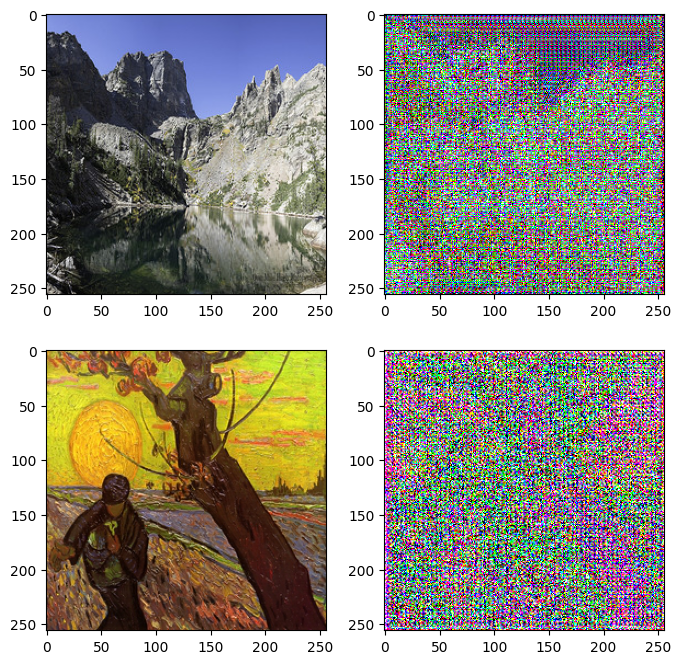

In [16]:
to_B = gen_g(sample_A)
to_A = gen_f(sample_B)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_A, to_B, sample_B, to_A]

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
# plt.figure(figsize=(8, 8))

# plt.subplot(121)
# plt.title('Is a real zebra?')
# plt.imshow(dis_y(sample_B)[0, ..., -1], cmap='RdBu_r')

# plt.subplot(122)
# plt.title('Is a real horse?')
# plt.imshow(dis_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

# plt.show()

In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1

In [21]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 5 * loss

In [22]:
gen_g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_f_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

dis_x_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dis_y_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
def generate_images(model, model2, test_input):
    prediction = model(test_input)
    reverse = model2(prediction)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0], reverse[0]]
    title = ['Input Image', 'Predicted Image', 'Reverse']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [24]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = gen_g(real_x, training=True)
        cycled_x = gen_f(fake_y, training=True)

        fake_x = gen_f(real_y, training=True)
        cycled_y = gen_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = gen_f(real_x, training=True)
        same_y = gen_g(real_y, training=True)

        disc_real_x = dis_x(real_x, training=True)
        disc_real_y = dis_y(real_y, training=True)

        disc_fake_x = dis_x(fake_x, training=True)
        disc_fake_y = dis_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, dis_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, dis_y.trainable_variables)

    # Apply the gradients to the optimizer
    gen_g_opt.apply_gradients(zip(generator_g_gradients, gen_g.trainable_variables))

    gen_f_opt.apply_gradients(zip(generator_f_gradients, gen_f.trainable_variables))

    dis_x_opt.apply_gradients(zip(discriminator_x_gradients, dis_x.trainable_variables))

    dis_y_opt.apply_gradients(zip(discriminator_y_gradients, dis_y.trainable_variables))

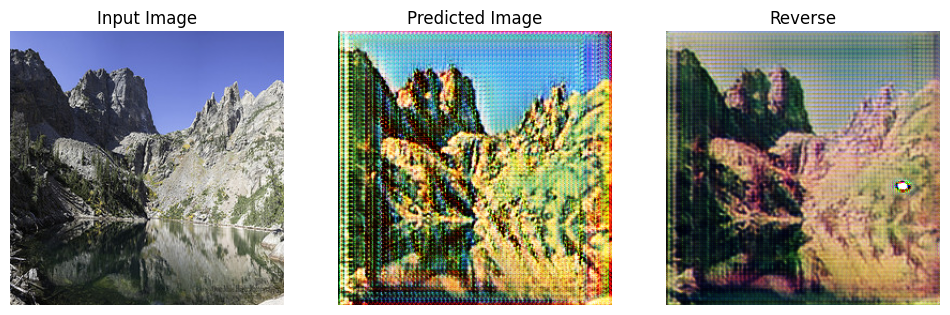

Time taken for epoch 1 is 557.8880200386047 sec

.

KeyboardInterrupt: ignored

In [43]:
for epoch in range(20):
    start = time.time()
    n = 0
    choice = np.random.choice(trainA.shape[0], trainB.shape[0])
    trainA1 = trainA[choice]
    for image_x, image_y in zip(trainA1, trainB):
        train_step(image_x.reshape(1,256,256,3), image_y.reshape(1,256,256,3))
        if n % 10 == 0:
          print ('.', end='')
        n += 1
    clear_output(wait=True)
    generate_images(gen_g, gen_f, sample_A)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [28]:
gen_g.save("gen_g_vang.h5")

In [29]:
gen_f.save("gen_f_vang.h5")

In [34]:
dis_x.save("dis_x_vang.h5")

In [35]:
dis_y.save("dis_y_vang.h5")

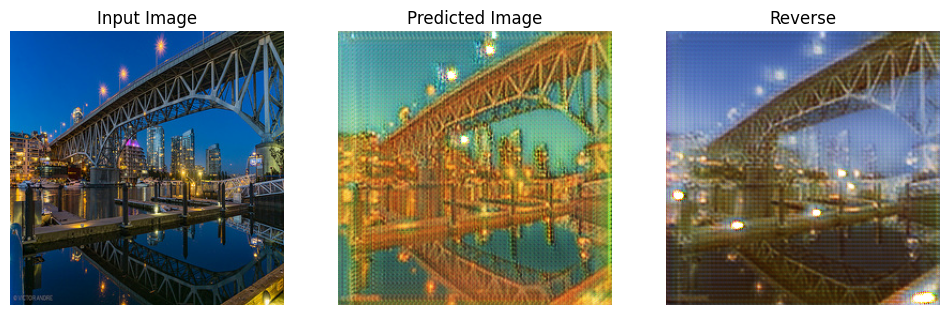

In [38]:
generate_images(gen_g, gen_f, trainA[3].reshape(1,256,256,3))

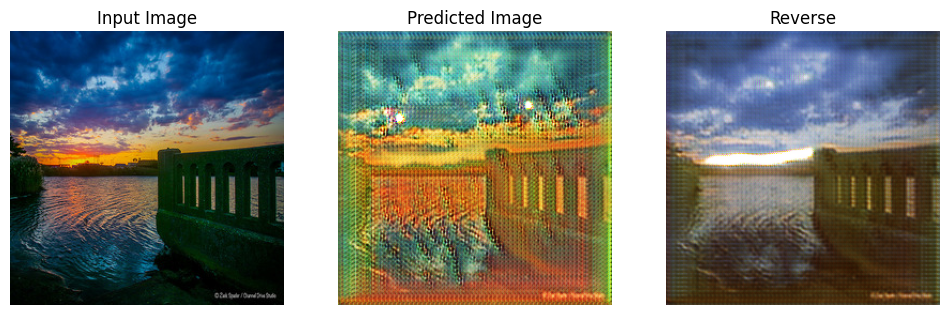

In [41]:
generate_images(gen_g, gen_f, trainA[380].reshape(1,256,256,3))

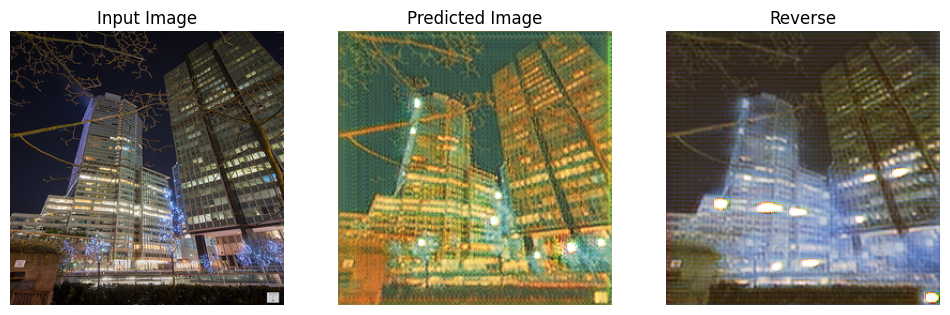

In [42]:
generate_images(gen_g, gen_f, trainA[4213].reshape(1,256,256,3))